## **Importing dependencies**

In [24]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import torchvision
import tarfile
from zipfile import ZipFile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [25]:
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [26]:
torch.__version__

'1.12.0+cu113'

In [27]:
import torchvision
torchvision.__version__

'0.13.0+cu113'

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [30]:
with ZipFile('/content/drive/MyDrive/dataset.zip', 'r') as zip:
    zip.extractall(path='./data')

In [43]:
dir_path='./data/dataset/'
folders= os.listdir(dir_path)
print(folders)
for i in folders:
  print(os.listdir(dir_path+'/'+i))

['training_data', 'validation_data', 'testing_data']
['smoking', 'notsmoking']
['smoking', 'notsmoking']
['abc149.jpg', 'abc378.jpg', 'abc252.jpg', 'abc263.jpg', 'abc205.jpg', 'abc363.jpg', 'abc187.jpg', 'abc233.jpg', 'abc285.jpg', 'abc230.jpg', 'abc310.jpg', 'abc139.jpg', 'abc218.jpg', 'abc145.jpg', 'abc277.jpg', 'abc153.jpg', 'abc026.jpg', 'abc161.jpg', 'abc105.jpg', 'abc075.jpg', 'abc015.jpg', 'abc123.jpg', 'abc053.jpg', 'abc041.jpg', 'abc337.jpg', 'abc240.jpg', 'abc196.jpg', 'abc120.jpg', 'abc338.jpg', 'abc108.jpg', 'abc054.jpg', 'abc116.jpg', 'abc397.jpg', 'abc276.jpg', 'abc072.jpg', 'abc119.jpg', 'abc296.jpg', 'abc360.jpg', 'abc198.jpg', 'abc173.jpg', 'abc109.jpg', 'abc326.jpg', 'abc101.jpg', 'abc086.jpg', 'abc380.jpg', 'abc246.jpg', 'abc334.jpg', 'abc374.jpg', 'abc095.jpg', 'abc129.jpg', 'abc284.jpg', 'abc220.jpg', 'abc057.jpg', 'abc189.jpg', 'abc302.jpg', 'abc228.jpg', 'abc163.jpg', 'abc184.jpg', 'abc100.jpg', 'abc180.jpg', 'abc011.jpg', 'abc330.jpg', 'abc350.jpg', 'abc185.jpg'

In [44]:
input_path = "./data/dataset/"

## **Creating pyTorch generators**

In [45]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'training_data':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation_data':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'training_data': 
    datasets.ImageFolder(input_path + 'training_data/', data_transforms['training_data']),
    'validation_data': 
    datasets.ImageFolder(input_path + 'validation_data/', data_transforms['validation_data'])
}

dataloaders = {
    'training_data':
    torch.utils.data.DataLoader(image_datasets['training_data'],
                                batch_size=32,
                                shuffle=True), 
    'validation_data':
    torch.utils.data.DataLoader(image_datasets['validation_data'],
                                batch_size=32,
                                shuffle=False,) 
}

## **Creating the network**

In [46]:
model = models.resnet50(weights=None).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

## **Training the model**

In [48]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['training_data', 'validation_data']:
            if phase == 'training_data':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'training_data':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [49]:
model_trained = train_model(model, criterion, optimizer, num_epochs=100)

Epoch 1/100
----------
training_data loss: 0.7424, acc: 0.4988
validation_data loss: 0.6989, acc: 0.5000
Epoch 2/100
----------
training_data loss: 0.6980, acc: 0.4975
validation_data loss: 0.7011, acc: 0.5000
Epoch 3/100
----------
training_data loss: 0.6914, acc: 0.5354
validation_data loss: 0.6972, acc: 0.4850
Epoch 4/100
----------
training_data loss: 0.6860, acc: 0.5379
validation_data loss: 0.6993, acc: 0.4975
Epoch 5/100
----------
training_data loss: 0.6878, acc: 0.5404
validation_data loss: 0.6953, acc: 0.5000
Epoch 6/100
----------
training_data loss: 0.6807, acc: 0.5596
validation_data loss: 0.6977, acc: 0.4850
Epoch 7/100
----------
training_data loss: 0.6793, acc: 0.5578
validation_data loss: 0.6928, acc: 0.5150
Epoch 8/100
----------
training_data loss: 0.6784, acc: 0.5509
validation_data loss: 0.6900, acc: 0.5700
Epoch 9/100
----------
training_data loss: 0.6711, acc: 0.5969
validation_data loss: 0.6863, acc: 0.5650
Epoch 10/100
----------
training_data loss: 0.6649, acc

## **Save and load the Model**

In [50]:
!mkdir models
!mkdir models/pytorch

mkdir: cannot create directory ‘models’: File exists
mkdir: cannot create directory ‘models/pytorch’: File exists


In [51]:
torch.save(model_trained.state_dict(), 'models/pytorch/weights.h5')

In [52]:
model = models.resnet50(weights=None).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))

<All keys matched successfully>

## **Making predictions**

In [70]:
validation_img_paths = ["validation_data/notsmoking/notsmoking_0112.jpg",
                        "validation_data/smoking/smoking_0107.jpg"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

In [71]:
validation_batch = torch.stack([data_transforms['validation_data'](img).to(device)
                                for img in img_list])

In [72]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[ 0.3825, -0.3230],
        [-0.5169,  0.3766]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [73]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[0.6694254 , 0.3305746 ],
       [0.29039916, 0.7096008 ]], dtype=float32)

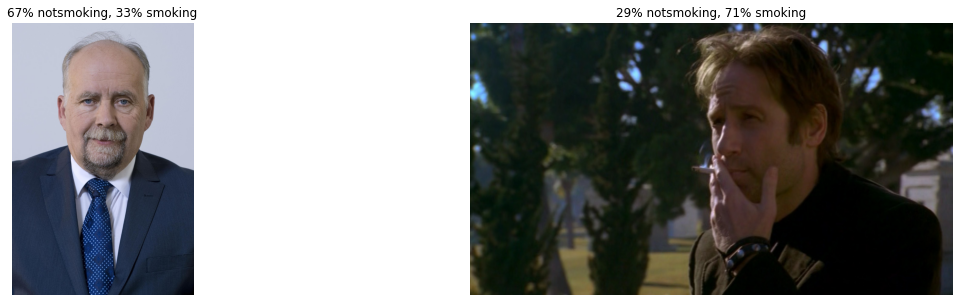

In [74]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% notsmoking, {:.0f}% smoking".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)